In [1]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e28764d1acbf655c09bf39ca0127a5b599f6cb8ec6d8b1fc1e4c038ad16a3113
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [3]:
# Create a session on Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("Hive").getOrCreate()

**Task 1: Data Overview**

In [7]:
# Read the given CSV file
df = spark.read.csv('BostonHousing.csv', header=True, inferSchema=True)

# Display the first few rows of the dataframe
df.show(5)

# Find and show the total number of records in the dataset
print(f"Total number of records: {df.count()}")


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows

Total number of records: 506


**Task 2: Descriptive Statistics**

In [8]:
# Calculate and display basic statistics for the "medv" column
medv_stats = df.select("medv").describe().show()

# Calculate and display the mean of the "rm" column
mean_rm = df.select("rm").groupBy().mean().first()[0]
print(f"Mean number of rooms per dwelling (rm): {mean_rm}")

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               506|
|   mean|22.532806324110698|
| stddev| 9.197104087379815|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+

Mean number of rooms per dwelling (rm): 6.284634387351787


**Task 3: Data Exploration**

In [13]:
# Identify the property with the highest crime rate ("crim")
highest_crim = df.orderBy(df.crim.desc()).first()
print("Property with the highest crime rate:")
print(highest_crim)

# Find the property with the lowest median home value ("medv")
lowest_medv = df.orderBy(df.medv.asc()).first()
print("Property with the lowest median home value:")
print(lowest_medv)

Property with the highest crime rate:
Row(crim=88.9762, zn=0.0, indus=18.1, chas=0, nox=0.671, rm=6.968, age=91.9, dis=1.4165, rad=24, tax=666, ptratio=20.2, b=396.9, lstat=17.21, medv=10.4)
Property with the lowest median home value:
Row(crim=38.3518, zn=0.0, indus=18.1, chas=0, nox=0.693, rm=5.453, age=100.0, dis=1.4896, rad=24, tax=666, ptratio=20.2, b=396.9, lstat=30.59, medv=5.0)


**Task 4: Data Distribution Analysis**

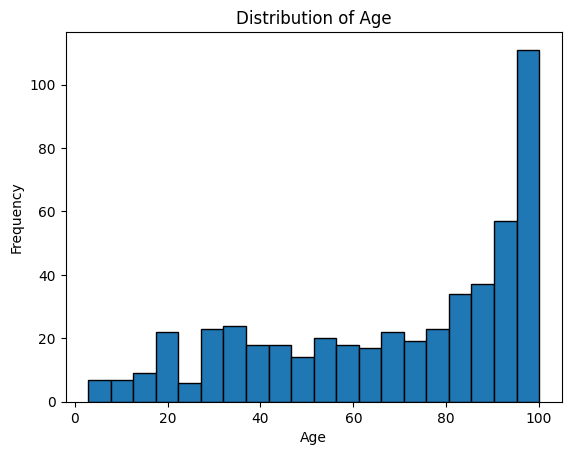

In [14]:
import matplotlib.pyplot as plt

# Create a histogram showing the distribution of the "age" column
age_data = df.select("age").rdd.flatMap(lambda x: x).collect()
plt.hist(age_data, bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [15]:
# Calculate and report the percentage of properties with a "chas" value of 1
total_chas_1 = df.filter(df.chas == 1).count()
percentage_chas_1 = (total_chas_1 / df.count()) * 100
print(f"Percentage of properties with 'chas' value of 1: {percentage_chas_1:.2f}%")

Percentage of properties with 'chas' value of 1: 6.92%


**Task 5: Correlation Analysis**

In [16]:
# Calculate the correlation coefficient between "rm" and "medv"
corr_rm_medv = df.corr("rm", "medv")
print(f"Correlation coefficient between 'rm' and 'medv': {corr_rm_medv}")

Correlation coefficient between 'rm' and 'medv': 0.6953599470715401


The correlation coefficient of 0.695 between rm and medv suggests a positive and moderately strong relationship. This implies that properties with more rooms tend to have higher median home values.

In [17]:
# Calculate the correlation coefficient between "ptratio" and "nox"
corr_ptratio_nox = df.corr("ptratio", "nox")
print(f"Correlation coefficient between 'ptratio' and 'nox': {corr_ptratio_nox}")

Correlation coefficient between 'ptratio' and 'nox': 0.18893267711276893


**Task 6: Advanced Querying**

In [18]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("boston_housing")

# Identify and display the top 5 neighborhoods with the highest median home values ("medv")
top_5_neighborhoods = spark.sql("""
    SELECT *
    FROM boston_housing
    ORDER BY medv DESC
    LIMIT 5
""")
top_5_neighborhoods.show()

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|1.51902| 0.0|19.58|   1|0.605|8.375|93.9| 2.162|  5|403|   14.7|388.45| 3.32|50.0|
|0.01381|80.0| 0.46|   0|0.422|7.875|32.0|5.6484|  4|255|   14.4|394.23| 2.97|50.0|
|2.01019| 0.0|19.58|   0|0.605|7.929|96.2|2.0459|  5|403|   14.7| 369.3|  3.7|50.0|
|1.83377| 0.0|19.58|   1|0.605|7.802|98.2|2.0407|  5|403|   14.7|389.61| 1.92|50.0|
|1.46336| 0.0|19.58|   0|0.605|7.489|90.8|1.9709|  5|403|   14.7|374.43| 1.73|50.0|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+



In [19]:
# Calculate and show the average property age for neighborhoods with a "chas" value of 1
avg_age_chas_1 = spark.sql("""
    SELECT AVG(age) AS avg_age_chas_1
    FROM boston_housing
    WHERE chas = 1
""")
avg_age_chas_1.show()

+-----------------+
|   avg_age_chas_1|
+-----------------+
|77.50000000000001|
+-----------------+



In [20]:
# Calculate and show the average property age for neighborhoods with a "chas" value of 0
avg_age_chas_0 = spark.sql("""
    SELECT AVG(age) AS avg_age_chas_0
    FROM boston_housing
    WHERE chas = 0
""")
avg_age_chas_0.show()

+-----------------+
|   avg_age_chas_0|
+-----------------+
|67.91167728237794|
+-----------------+



**Task 7: Visualization**

In [21]:
# Create a Hive view named "property_age_view"
spark.sql("""
    CREATE OR REPLACE TEMP VIEW property_age_view AS
    SELECT age, medv
    FROM boston_housing
""")

DataFrame[]

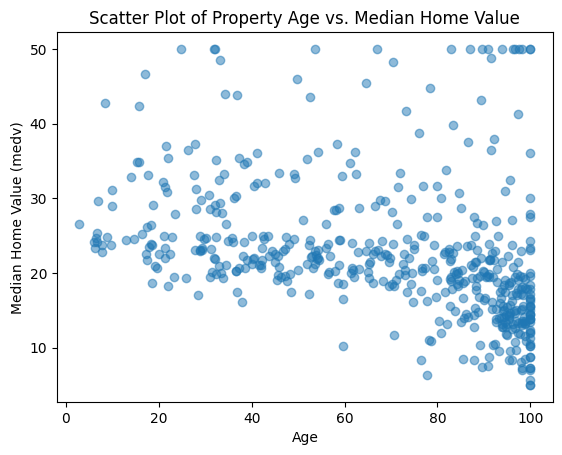

In [22]:
# Retrieve data from the view
property_age_data = spark.sql("SELECT * FROM property_age_view").toPandas()

# Plot a scatter plot of property age against median home value
plt.scatter(property_age_data['age'], property_age_data['medv'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Median Home Value (medv)')
plt.title('Scatter Plot of Property Age vs. Median Home Value')
plt.show()

**Task 8: Outliers Detection**

In [23]:
# Identify and report properties with a "crim" value greater than 10
outliers = df.filter(df.crim > 10)
outliers.show()

+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim| zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|13.5222|0.0| 18.1|   0|0.631|3.863|100.0|1.5106| 24|666|   20.2|131.42|13.33|23.1|
|11.1081|0.0| 18.1|   0|0.668|4.906|100.0|1.1742| 24|666|   20.2| 396.9|34.77|13.8|
|18.4982|0.0| 18.1|   0|0.668|4.138|100.0| 1.137| 24|666|   20.2| 396.9|37.97|13.8|
|19.6091|0.0| 18.1|   0|0.671|7.313| 97.9|1.3163| 24|666|   20.2| 396.9|13.44|15.0|
| 15.288|0.0| 18.1|   0|0.671|6.649| 93.3|1.3449| 24|666|   20.2|363.02|23.24|13.9|
|23.6482|0.0| 18.1|   0|0.671| 6.38| 96.2|1.3861| 24|666|   20.2| 396.9|23.69|13.1|
|17.8667|0.0| 18.1|   0|0.671|6.223|100.0|1.3861| 24|666|   20.2|393.74|21.78|10.2|
|88.9762|0.0| 18.1|   0|0.671|6.968| 91.9|1.4165| 24|666|   20.2| 396.9|17.21|10.4|
|15.8744|0.0| 18.1|   0|0.671|6.545| 99.1|1.5192| 24|666|   20.2| 396.9|21.0

Detecting outliers is a vital step in data analysis. It helps in ensuring data quality, improving model performance, and gaining insights into extreme cases that might require special attention. In the the Boston Housing dataset, identifying properties with exceptionally high crime rates can provide valuable insights for real estate stakeholders, policymakers, and researchers.

**Task 9: Hypothesis Testing**

Hypothesis
Null Hypothesis (H0): There is no significant relationship between the average number of rooms and the median home value.
Alternative Hypothesis (H1): There is a significant relationship between the average number of rooms and the median home value.

In [24]:
from scipy import stats
import math

# Calculate the correlation coefficient between "rm" and "medv"
corr_rm_medv = df.corr("rm", "medv")
print(f"Correlation coefficient between 'rm' and 'medv': {corr_rm_medv}")

# Number of observations
n = df.count()

# Calculate the t-statistic
t_statistic = corr_rm_medv * math.sqrt((n - 2) / (1 - corr_rm_medv**2))
print(f"T-statistic: {t_statistic}")

# Degrees of freedom
df_degrees = n - 2

# Calculate the p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=df_degrees))
print(f"P-value: {p_value}")

# Decision
alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis: There is a significant relationship between 'rm' and 'medv'.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between 'rm' and 'medv'.")

Correlation coefficient between 'rm' and 'medv': 0.6953599470715401
T-statistic: 21.7220335115382
P-value: 0.0
Reject the null hypothesis: There is a significant relationship between 'rm' and 'medv'.
